In [1]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# results_folder = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster'
# results_folder_swapped = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_swapped_delta_materials'

# returns original delta_materials data structure (used to generate MMA plots)
results_folder_bishop_change = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_3_bishop_change'

# return translated translated_delta_materials data structure (used to generate beta value results)
results_folder_all_translated = r'/scratch/gpfs/allenwu/analysis_results_Mar_2023_cluster_all_translated'

In [2]:
# aggregate data in order of job_idx (such that delta_materials and move_match line up)
job_indices_hm = defaultdict(list)
moves_per_run = 22000
n_total_runs = 300

for i in range(0, n_total_runs):
    start_idx = i * moves_per_run
    end_idx = ((i+1)*moves_per_run) - 1
    job_indices_hm[i] = [start_idx, end_idx]
    
# Iterate over the sorted hm and save the files
all_delta_materials = []
all_move_matches = []        
for job_idx, [start_idx, end_idx] in job_indices_hm.items():
    if job_idx == 0:
        continue
        
    delta_materials_file_name = f'job_{job_idx}_start_{start_idx}_end_{end_idx}_delta_materials.npy'
    move_match_file_name = f'job_{job_idx}_start_{start_idx}_end_{end_idx}_move_match.npy'

    delta_materials_path = os.path.join(results_folder_all_translated, delta_materials_file_name)
    # Load the delta_materials array from the file
    with open(delta_materials_path, 'rb') as f:
        delta_materials = np.load(f, allow_pickle=True)
        all_delta_materials.append(delta_materials)

    move_match_path = os.path.join(results_folder_all_translated, move_match_file_name)
    # Load the move_match array from the file
    with open(move_match_path, 'rb') as f:
        move_matches = np.load(f, allow_pickle=True)
        all_move_matches.append(move_matches)
        
print(len(all_delta_materials[0]))
print(len(all_move_matches[0]))
          
# Concatenate all delta_materials arrays into a single array
combined_delta_materials = np.concatenate(all_delta_materials)
print(combined_delta_materials.shape)   # should be (6M, 36) --> correct!
# print(combined_delta_materials)

# Concatenate all move_match arrays into a single array
combined_move_matches = np.concatenate(all_move_matches)
print(combined_move_matches.shape)   # should be (6M,) --> correct!
# print(combined_move_matches)

21434
21434
(6415507, 36)
(6415507,)


In [3]:
# logistic regression results are a little hard to interpret --> do this alternative construction (conditional means for each of 36 events on accuracy)
# we ultimately want a vector of length 36 (with conditional probs for each event) + accuracy prob if there was no event
conditional_totals = [[0, 0] for i in range(36)]   # (total_correct, total) for each event tracked
total_correct = 0
for i, events in enumerate(combined_delta_materials):
    if combined_move_matches[i] == 1:
        total_correct += 1
        
    # events vector is of length 36 too
    for j in range(len(events)):
        if events[j] == 1:
            conditional_totals[j][1] += 1
            
            if combined_move_matches[i] == 1:
                conditional_totals[j][0] += 1
            
conditional_accuracies = [round(conditional_totals[i][0] / conditional_totals[i][1], 3) for i in range(len(conditional_totals))]
# print("conditional accuracies of all 36 events:\n", conditional_accuracies)      

conditional_accuracies_table = [conditional_accuracies[i:i+6] for i in range(0, len(conditional_accuracies), 6)]
print("Conditional accuracies in a 6x6 table format:")
for row in conditional_accuracies_table:
    formatted_row = ["{:.3f}".format(prob) for prob in row]
    print(formatted_row)
    
unconditional_accuracy = round(total_correct / len(combined_move_matches), 3)
print("accuracy if no event considered:\n", unconditional_accuracy)

Conditional accuracies in a 6x6 table format:
['0.308', '0.548', '0.605', '0.681', '0.718', '0.737']
['0.378', '0.384', '0.417', '0.424', '0.443', '0.402']
['0.387', '0.363', '0.370', '0.358', '0.420', '0.396']
['0.385', '0.373', '0.377', '0.373', '0.403', '0.396']
['0.387', '0.375', '0.365', '0.362', '0.391', '0.385']
['0.386', '0.379', '0.363', '0.365', '0.390', '0.390']
accuracy if no event considered:
 0.384


In [3]:
# remove 0th, 6th, 12th, 18th, 24th, 30th columns (all cases where nothing is captured across 6 depths)
# only need to run once every time combined_delta_materials is constructed from scratch
combined_delta_materials = np.delete(combined_delta_materials, [0,6,12,18,24,30], axis=1)

In [4]:
# run a logistic regression from translated_delta_materials to combined_move_matches --> 36 beta weights
# Reshape combined_move_match to match the shape of translated_delta_materials
combined_move_matches = combined_move_matches.reshape(-1, 1)

# Create a logistic regression model
log_reg = LogisticRegression(fit_intercept=True, C=float("inf"))

# Fit the model to your data
log_reg.fit(combined_delta_materials, combined_move_matches)

# Retrieve the coefficients (beta weights) from the trained model
beta_weights = log_reg.coef_
intercept = log_reg.intercept_

np.set_printoptions(suppress=True)

# The shape of beta_weights will be (1, 36), containing the coefficients for each column in translated_delta_materials
beta_weights = beta_weights.reshape(6,5)
print(beta_weights)
print("intercept:", intercept)

# 3 trends here:
# 1.) when you gain pieces, gaining a higher valued piece makes you more accurate
# 2.) when you lose pieces, losing a higher valued piece makes you less accurate (people value bishops more than rooks when losing (or ppl are good at rook sacrifices), value bishops more than knights consistently)
# 3.) all these effects get smaller with increasing depths

# removing all cols where no capture occurs = more meaningful intercept --> more meaningful + and - values for other values too (if hurting or helping you make right move)

# relate results back to Huys paper
# problem: don't know what exact person's valuation function is relative to stockfish

# 3 plots tentatively (all, all + elos side by side, all + times side by side)
# one idea: x-axis = pawn,knight,bishop,rook,queen, y-axis=beta values (one colored line for each depth, solid line for active move/even rows, dotted line for opponent move/odd rows)

/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[[ 1.08619052  1.60311927  1.85703356  2.11984427  2.55289407]
 [-0.2495824  -0.62466106 -0.84059129 -0.7950022  -1.44785557]
 [-0.03982281  0.20522113  0.23750645  0.41473965  0.61955567]
 [-0.04477079 -0.20788147 -0.27639157 -0.19428205 -0.41124187]
 [-0.04903593  0.0256414   0.01995181  0.06642572  0.14936713]
 [ 0.02176525 -0.10399143 -0.13221313 -0.03166139 -0.09986826]]
intercept: [-0.740722]


In [23]:
import numpy as np
import statsmodels.api as sm

# Reshape combined_move_match to match the shape of translated_delta_materials
combined_move_matches = combined_move_matches.reshape(-1, 1)

# Add constant term for intercept
combined_delta_materials_with_const = sm.add_constant(combined_delta_materials)
combined_delta_materials_with_const = np.array(combined_delta_materials_with_const, dtype=float)

# Create and fit the logistic regression model
logit_model = sm.Logit(combined_move_matches, combined_delta_materials_with_const)
if combined_delta_materials_with_const.shape[1] > 1:
    logit_result = logit_model.fit()
else:
    logit_result = logit_model.fit()

# Retrieve the coefficients (beta weights) from the trained model
beta_weights = logit_result.params[1:]  # Exclude the intercept
intercept = logit_result.params[0]
print(logit_result.summary)

# Reshape beta_weights for interpretation
beta_weights = beta_weights.reshape(6, 5)

print("Beta Weights:")
print(beta_weights)
print("Intercept:", intercept)

Optimization terminated successfully.
         Current function value: 0.620658
         Iterations 5
<bound method BinaryResults.summary of <statsmodels.discrete.discrete_model.LogitResults object at 0x15074df03f40>>
Beta Weights:
[[ 1.08617869  1.6031123   1.8570304   2.11980647  2.55275271]
 [-0.24957114 -0.62466437 -0.84061586 -0.79495075 -1.4476983 ]
 [-0.03979496  0.20527145  0.23752524  0.41483596  0.61950636]
 [-0.04477432 -0.20793206 -0.27646568 -0.19426927 -0.41117905]
 [-0.04903066  0.02566418  0.02001122  0.06648945  0.14923421]
 [ 0.02177065 -0.10400401 -0.1322328  -0.03184203 -0.09974072]]
Intercept: -0.7407212098663645


In [34]:
print(logit_result.bse[1:].reshape(6,5))

[[0.00271484 0.00420623 0.00441695 0.00602367 0.00812352]
 [0.00309993 0.00481815 0.0049588  0.00636258 0.00821325]
 [0.00296222 0.00496087 0.0050071  0.00593159 0.00748548]
 [0.00303239 0.00501926 0.00528749 0.0064584  0.00806606]
 [0.00291027 0.00500331 0.00513449 0.00613821 0.00749428]
 [0.0028432  0.00464657 0.00498304 0.00599244 0.00698391]]


In [24]:
print(logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              6415507
Model:                          Logit   Df Residuals:                  6415476
Method:                           MLE   Df Model:                           30
Date:                Thu, 11 Apr 2024   Pseudo R-squ.:                 0.06784
Time:                        16:51:42   Log-Likelihood:            -3.9818e+06
converged:                       True   LL-Null:                   -4.2716e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7407      0.001   -595.045      0.000      -0.743      -0.738
x1             1.0862      0.003    400.090      0.000       1.081       1.091
x2             1.6031      0.004    381.128      0.0

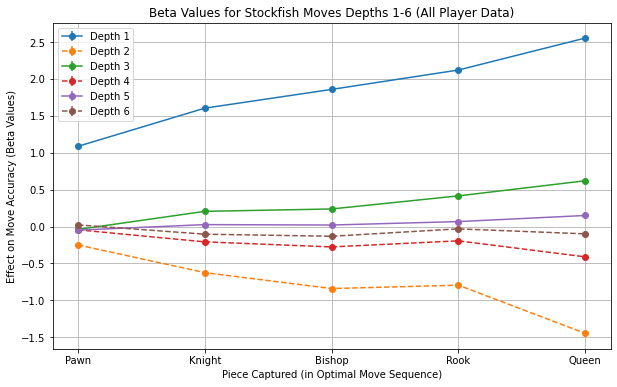

In [36]:
# create the line plot for all player data
# Depth labels
depth_labels = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6']

# Pieces labels
piece_labels = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen']

# Adjust figure size
plt.figure(figsize=(10, 6))

# Plotting
for i in range(len(depth_labels)):
    if i % 2 == 0:
        plt.errorbar(piece_labels, beta_weights[i], yerr=logit_result.bse[1:].reshape(6,5)[i], marker='o', linestyle='-', label=depth_labels[i])
    else:
        plt.errorbar(piece_labels, beta_weights[i], yerr=logit_result.bse[1:].reshape(6,5)[i], marker='o', linestyle='--', label=depth_labels[i])

plt.xlabel('Piece Captured (in Optimal Move Sequence)')
plt.ylabel('Effect on Move Accuracy (Beta Values)')
plt.title('Beta Values for Stockfish Moves Depths 1-6 (All Player Data)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# to address "don't know what exact person's valuation function is relative to stockfish" in relation to Huys' paper
# only include moves where active player could gain large positive material exchange for d5+6 that makes up for previous exchanges
# makes our trees quite similar to huys trees (run regression for just d1-d4)
# would confidently see if people are missing big opportunities that occur at later depth by pruning at earlier depth
# NOTE: no 0th col from the original data structure since removed that col
# NOT USING NOW
material_hm = {0:1, 1:3, 2:3, 3:5, 4:9}
filtered_combined_delta_materials = []
filtered_combined_move_matches = []
for i, events in enumerate(combined_delta_materials):
    events = events.reshape(6,5)
    
    # for every move, calculate net exchange of d1-d4 moves
    full_exchange = 0
    for j, depth_exchange in enumerate(events):
        for k in range(len(depth_exchange)):
            if depth_exchange[k] == 1:
                if j % 2 == 0:
                    full_exchange += material_hm[k]
                else:
                    full_exchange -= material_hm[k]
                break
#     if prior_exchange >= 0:
#         continue
    
#     # calculate net exchange of d5-d6 moves
#     next_exchange = 0
#     for j, depth_exchange in enumerate(events[4:]):
#         for k in range(len(depth_exchange)):
#             if depth_exchange[k] == 1:
#                 if j % 2 == 0:
#                     next_exchange += material_hm[k]
#                 else:
#                     next_exchange -= material_hm[k]
#                 break
                
    # add row if next_exchange > abs(prior_exchange), where prior_exchange is negative
    if full_exchange >= 3:
        events = events.reshape(-1)
        filtered_combined_delta_materials.append(events)
        filtered_combined_move_matches.append(combined_move_matches[i])
        
print(len(filtered_combined_delta_materials), len(filtered_combined_delta_materials[0]))
print(len(filtered_combined_move_matches))

624425 30
624425


In [20]:
# run a logistic regression from translated_delta_materials to combined_move_matches --> 36 beta weights
# Reshape combined_move_match to match the shape of translated_delta_materials
filtered_combined_move_matches = filtered_combined_move_matches.reshape(-1, 1)
filtered_combined_delta_materials = np.array(filtered_combined_delta_materials)
filtered_combined_move_matches = np.array(filtered_combined_move_matches)

# Create a logistic regression model
filtered_log_reg = LogisticRegression(fit_intercept=True, C=float("inf"))

# Fit the model to your data
filtered_log_reg.fit(filtered_combined_delta_materials, filtered_combined_move_matches)

# Retrieve the coefficients (beta weights) from the trained model
filtered_beta_weights = filtered_log_reg.coef_
filtered_intercept = filtered_log_reg.intercept_

np.set_printoptions(suppress=True)

# The shape of beta_weights will be (1, 36), containing the coefficients for each column in translated_delta_materials
filtered_beta_weights = filtered_beta_weights.reshape(6,5)
print(filtered_beta_weights)
print("intercept:", filtered_intercept)

/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[[ 0.58334156  1.30414073  1.47373859  1.69534476  2.00412187]
 [-0.0642928  -0.33667973 -0.44064094 -0.37991122 -1.09017034]
 [-0.18637891 -0.28122232 -0.28424352 -0.13560276  0.02379582]
 [ 0.12146823  0.04723304  0.01150518  0.02002804 -0.03424075]
 [-0.11354318 -0.35006955 -0.33978374 -0.36638797 -0.37880072]
 [ 0.07472392 -0.01180465  0.0876565   0.06671164  0.21483748]]
intercept: [-0.13458408]


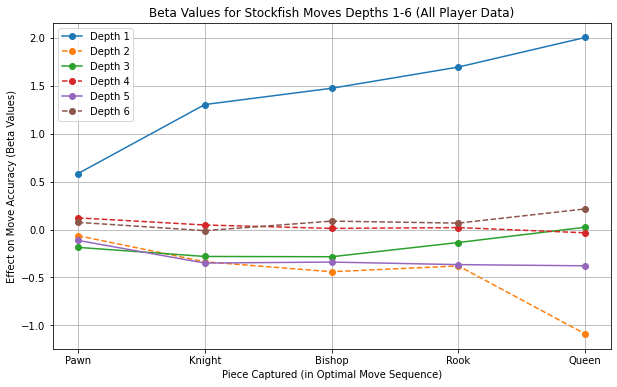

In [21]:
# create the line plot for all player data
# Depth labels
depth_labels = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4', 'Depth 5', 'Depth 6']

# Pieces labels
piece_labels = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen']

# Adjust figure size
plt.figure(figsize=(10, 6))

# Plotting
for i in range(len(depth_labels)):
    if i % 2 == 0:
        plt.plot(piece_labels, filtered_beta_weights[i], marker='o', linestyle='-', label=depth_labels[i])
    else:
        plt.plot(piece_labels, filtered_beta_weights[i], marker='o', linestyle='--', label=depth_labels[i])

plt.xlabel('Piece Captured (in Optimal Move Sequence)')
plt.ylabel('Effect on Move Accuracy (Beta Values)')
plt.title('Beta Values for Stockfish Moves Depths 1-6 (All Player Data)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
filtered_combined_delta_materials = np.array(filtered_combined_delta_materials)
filtered_combined_move_matches = np.array(filtered_combined_move_matches)
print("filtered delta materials shape:", filtered_combined_delta_materials.shape)
print("filtered move matches shape:", filtered_combined_move_matches.shape)

# only run regression on d1-d4 moves (only need to run once
filtered_combined_delta_materials_d1_d4 = np.delete(filtered_combined_delta_materials, range(20, 30), axis=1)
print(filtered_combined_delta_materials_d1_d4.shape)

filtered delta materials shape: (624425, 30)
filtered move matches shape: (624425, 1)
(624425, 20)


In [16]:
# run a logistic regression from translated_delta_materials to combined_move_matches --> 36 beta weights
# Reshape combined_move_match to match the shape of translated_delta_materials
filtered_combined_move_matches = filtered_combined_move_matches.reshape(-1, 1)

# Create a logistic regression model
filtered_log_reg = LogisticRegression(fit_intercept=True, C=float("inf"))

# Fit the model to your data
filtered_log_reg.fit(filtered_combined_delta_materials_d1_d4, filtered_combined_move_matches)

# Retrieve the coefficients (beta weights) from the trained model
filtered_beta_weights = filtered_log_reg.coef_
filtered_intercept = filtered_log_reg.intercept_

np.set_printoptions(suppress=True)

# The shape of beta_weights will be (1, 36), containing the coefficients for each column in translated_delta_materials
filtered_beta_weights = filtered_beta_weights.reshape(4,5)
print(filtered_beta_weights)
print("intercept:", filtered_intercept)

/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[[ 0.61200357  1.51599148  1.69085369  1.92488766  2.27513587]
 [-0.0957376  -0.46446916 -0.57015181 -0.53362443 -1.37865326]
 [-0.17218434 -0.104427   -0.11237918  0.08418956  0.34724885]
 [ 0.06758112 -0.11532332 -0.15521845 -0.17608717 -0.37689176]]
intercept: [-0.40552284]


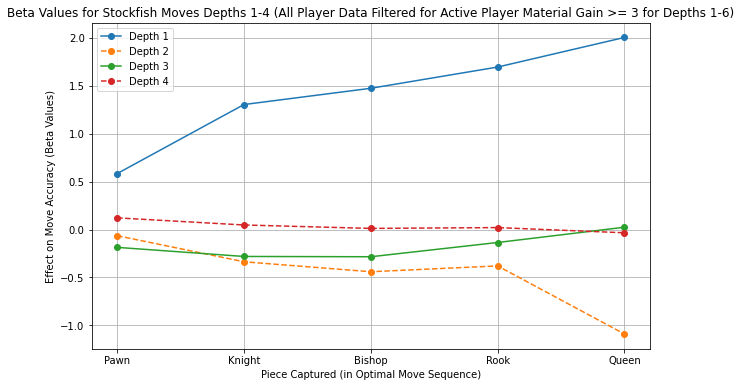

In [38]:
# create the line plot for all player data
# Depth labels
depth_labels = ['Depth 1', 'Depth 2', 'Depth 3', 'Depth 4']

# Pieces labels
piece_labels = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen']

# Adjust figure size
plt.figure(figsize=(10, 6))

# Plotting
for i in range(len(depth_labels)):
    if i % 2 == 0:
        plt.plot(piece_labels, filtered_beta_weights[i], marker='o', linestyle='-', label=depth_labels[i])
    else:
        plt.plot(piece_labels, filtered_beta_weights[i], marker='o', linestyle='--', label=depth_labels[i])

plt.xlabel('Piece Captured (in Optimal Move Sequence)')
plt.ylabel('Effect on Move Accuracy (Beta Values)')
plt.title('Beta Values for Stockfish Moves Depths 1-4 (All Player Data Filtered for Active Player Material Gain >= 3 for Depths 1-6)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
def custom_sum(delta_materials_row):
    total = 0
    for val in delta_materials_row:
        if val == 4:
            total += 3
        else:
            total += val
    return total

def custom_max(delta_materials_row):
    max_val = max(delta_materials_row)
    return 3 if max_val == 4 else max_val

def custom_immediate_val_1(delta_materials_row):
    return 3 if delta_materials_row[0] == 4 else delta_materials_row[0]

def custom_immediate_val_2(delta_materials_row):
    return 3 if delta_materials_row[1] == 4 else delta_materials_row[1]

def custom_immediate_val_3(delta_materials_row):
    return 3 if delta_materials_row[2] == 4 else delta_materials_row[2]

In [4]:
# now that we've combined all delta_materials.npy and move_match.npy files into a two lists,
# we must aggregate them appropraitely, as done before --> AGGREGATE!

# data aggregation step --> 3 starting heuristics
def active_material_sum(delta_materials, move_match):
    active_material_sum_hm = defaultdict(list)    # {sum : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_sum = custom_sum(active_player_delta)
        if active_material_sum not in active_material_sum_hm:
            active_material_sum_hm[active_material_sum] = [0, 0]
        
        if move_match[i] == 1:
            active_material_sum_hm[active_material_sum][0] += 1
            active_material_sum_hm[active_material_sum][1] += 1
        else:
            active_material_sum_hm[active_material_sum][1] += 1
    
    active_material_sums, accuracies = [], []
    for active_material_sum, [total_correct, total] in active_material_sum_hm.items():
        active_material_sums.append(active_material_sum)
        accuracies.append(total_correct / total)
    return [np.array(active_material_sums), np.array(accuracies)]


def active_material_max(delta_materials, move_match):
    active_material_max_hm = defaultdict(list)    # {max : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_max = custom_max(active_player_delta)
        if active_material_max not in active_material_max_hm:
            active_material_max_hm[active_material_max] = [0, 0]
        
        if move_match[i] == 1:
            active_material_max_hm[active_material_max][0] += 1
            active_material_max_hm[active_material_max][1] += 1
        else:
            active_material_max_hm[active_material_max][1] += 1
    
    active_material_maxes, accuracies = [], []
    for active_material_max, [total_correct, total] in active_material_max_hm.items():
        active_material_maxes.append(active_material_max)
        accuracies.append(total_correct / total)
    return [np.array(active_material_maxes), np.array(accuracies)]


def active_material_loss(delta_materials, move_match):
    active_material_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_loss = custom_sum(active_player_delta) - custom_sum(opponent_delta)
        if active_material_loss not in active_material_loss_hm:
            active_material_loss_hm[active_material_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_material_loss_hm[active_material_loss][0] += 1
            active_material_loss_hm[active_material_loss][1] += 1
        else:
            active_material_loss_hm[active_material_loss][1] += 1
            
    active_material_losses, accuracies = [], []
    for active_material_loss, [total_correct, total] in active_material_loss_hm.items():
        active_material_losses.append(active_material_loss)
        accuracies.append(total_correct / total)
    return [np.array(active_material_losses), np.array(accuracies)]

#--------------------------------new heuristics (April)----------------------------------------
# sanity check: active loss - opponent loss (2-ply)
def active_immediate_loss_1(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_1(active_player_delta) - custom_immediate_val_1(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        print("print:", active_immediate_loss, total_correct, total, total_correct/total)
    return [np.array(active_immediate_losses), np.array(accuracies)]

[11  3  0  2  1  6  5 10  9  8  4 12 14 13  7 15 17 19 18 21 23]


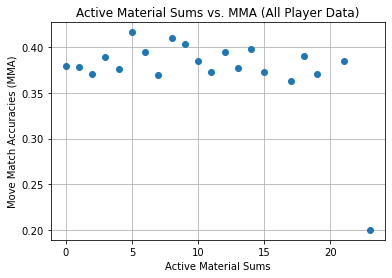

[9 3 0 1 5]


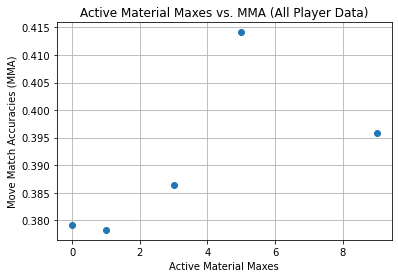

[  1   2   0  -5  -1   3  -6  -3   7  -9  -2  -4   9   6  10   5   4  -7
   8 -10  -8 -11  12 -12 -14 -15  14  13  11  19 -17  17 -13  15  16  18
 -19 -16 -18  20  21 -23]


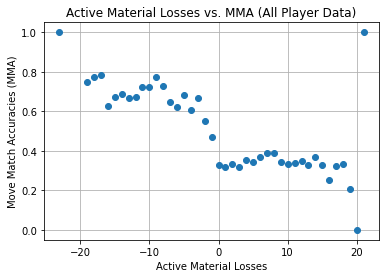

print: 1 95724 368708 0.25962007876151316
print: 0 1554749 4645801 0.33465682236497
print: -3 219664 288001 0.7627195738903685
print: 3 56812 199876 0.28423622646040547
print: 2 28997 81070 0.3576785494017516
print: -9 40071 47519 0.8432626949220312
print: -5 66341 81245 0.816554864914764
print: -1 263172 437268 0.601855155190867
print: -2 54160 71819 0.7541179910608613
print: 9 10081 40502 0.2489012888252432
print: 5 21102 65458 0.3223746524488985
print: -4 15032 18217 0.8251633089970907
print: 4 9011 23657 0.3809020585873103
print: 6 6566 16901 0.38849772202828237
print: -8 5456 6468 0.8435374149659864
print: -6 10744 13195 0.8142478211443729
print: 8 3728 9802 0.3803305447867782
[ 1  0 -3  3  2 -9 -5 -1 -2  9  5 -4  4  6 -8 -6  8]


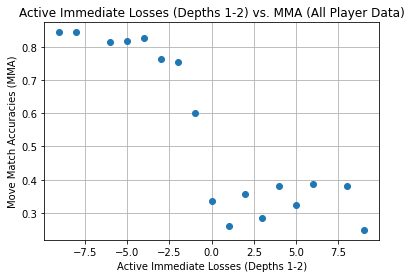

In [5]:
#------------------------plotting step---------------------------------

active_material_sums, accuracies_sums = active_material_sum(combined_delta_materials, combined_move_matches)
active_material_maxes, accuracies_maxes = active_material_max(combined_delta_materials, combined_move_matches)
active_material_losses, accuracies_losses = active_material_loss(combined_delta_materials, combined_move_matches)

plt.plot(active_material_sums, accuracies_sums, marker='o', linestyle='')
print(active_material_sums)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Sums')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Sums vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

plt.plot(active_material_maxes, accuracies_maxes, marker='o', linestyle='')
print(active_material_maxes)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Maxes')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Maxes vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

plt.plot(active_material_losses, accuracies_losses, marker='o', linestyle='')
print(active_material_losses)
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Losses')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Material Losses vs. MMA (All Player Data)')
plt.grid(True)
plt.show()


active_immediate_losses, accuracies_ail = active_immediate_loss_1(combined_delta_materials, combined_move_matches)
print(active_immediate_losses)
plt.plot(active_immediate_losses, accuracies_ail, marker='o', linestyle='')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 1-2)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 1-2) vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

In [6]:
# make this immediate loss plot for depths 3-4 (2nd move of each player) and depths 5-6 (3rd move of each player)
def active_immediate_loss_2(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_2(active_player_delta) - custom_immediate_val_2(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        print("print:", active_immediate_loss, total_correct, total, total_correct/total)
    return [np.array(active_immediate_losses), np.array(accuracies)]

def active_immediate_loss_3(delta_materials, move_match):
    active_immediate_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        immediate_loss = custom_immediate_val_3(active_player_delta) - custom_immediate_val_3(opponent_delta)
        if immediate_loss not in active_immediate_loss_hm:
            active_immediate_loss_hm[immediate_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_immediate_loss_hm[immediate_loss][0] += 1
            active_immediate_loss_hm[immediate_loss][1] += 1
        else:
            active_immediate_loss_hm[immediate_loss][1] += 1
            
    active_immediate_losses, accuracies = [], []
    for active_immediate_loss, [total_correct, total] in active_immediate_loss_hm.items():
        active_immediate_losses.append(active_immediate_loss)
        accuracies.append(total_correct / total)
        print("print:", active_immediate_loss, total_correct, total, total_correct/total)
    return [np.array(active_immediate_losses), np.array(accuracies)]

print: 0 1796236 4693248 0.3827276973217695
print: -1 158907 425778 0.37321561940729675
print: 3 75739 194345 0.3897141681031156
print: 1 151830 392095 0.38722758515155764
print: -3 88084 237321 0.371159737233536
print: -2 29401 73809 0.39833895595388097
print: 9 17324 41625 0.41619219219219217
print: -9 22214 56875 0.39057582417582415
print: -5 35012 81157 0.4314107224269009
print: 5 25150 60844 0.41335217934389584
print: -4 9704 23003 0.4218580185193236
print: 4 8302 20671 0.40162546562817475
print: 6 5150 13169 0.39106993697319464
print: 2 24981 67426 0.3704950612523359
print: -6 6925 16279 0.42539468026291544
print: 8 3673 10471 0.3507783401776335
print: -8 2778 7391 0.37586253551616833
[ 0 -1  3  1 -3 -2  9 -9 -5  5 -4  4  6  2 -6  8 -8]


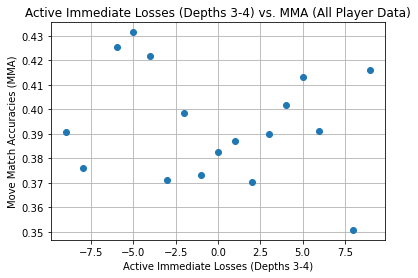

print: 0 1793413 4690462 0.3823531669161801
print: 3 77053 206976 0.372279877860235
print: -3 80242 214270 0.37449012927614694
print: -1 165408 424036 0.3900800875397372
print: 1 169977 427501 0.3976060874711404
print: 5 25295 62690 0.40349338012442176
print: -5 29240 73183 0.39954634272986894
print: 9 17531 43134 0.40643112162099504
print: 4 8367 21658 0.3863237602733401
print: -9 21634 54969 0.3935672833779039
print: -2 24628 67116 0.36694677871148457
print: 2 24654 66654 0.369880277252678
print: -8 2816 7393 0.38090085215744623
print: -4 8200 21412 0.3829628245843452
print: 6 4543 11828 0.3840886033141698
print: 8 3942 10341 0.381201044386423
print: -6 4467 11884 0.37588354089532144
[ 0  3 -3 -1  1  5 -5  9  4 -9 -2  2 -8 -4  6  8 -6]


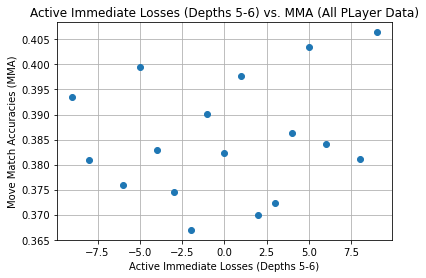

In [7]:
active_immediate_losses_2, accuracies_ail_2 = active_immediate_loss_2(combined_delta_materials, combined_move_matches)
print(active_immediate_losses_2)
plt.plot(active_immediate_losses_2, accuracies_ail_2, marker='o', linestyle='')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 3-4)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 3-4) vs. MMA (All Player Data)')
plt.grid(True)
plt.show()

active_immediate_losses_3, accuracies_ail_3 = active_immediate_loss_3(combined_delta_materials, combined_move_matches)
print(active_immediate_losses_3)
plt.plot(active_immediate_losses_3, accuracies_ail_3, marker='o', linestyle='')
# plt.xlim(-10, 10)
# plt.ylim(0.0, 1.1)
plt.xlabel('Active Immediate Losses (Depths 5-6)')
plt.ylabel('Move Match Accuracies (MMA)')
plt.title('Active Immediate Losses (Depths 5-6) vs. MMA (All PLayer Data)')
plt.grid(True)
plt.show()